# Implémentez un modèle de scoring

<hr/>

## I. Importation des Librairies utiles
<p>Plusieurs librairies sont utiles tout au long de l'étude. Elles sont importées dans cette section.</p>

In [1]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

# librairies pour les graphes
%pylab  inline
import seaborn as sns

# librairies pour les analyses
import pandas as pd
import numpy as np
import math
import time

# librairies pour les Models
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, average_precision_score, recall_score , fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import shap

Populating the interactive namespace from numpy and matplotlib


2022-01-11 20:47:19.463437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /var/lib/snapd/lib/gl:/var/lib/snapd/lib/gl32:/var/lib/snapd/void::/snap/jupyter/6/lib
2022-01-11 20:47:19.463477: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<hr/>

## II. Importation des données

In [2]:
data = pd.read_csv('../Results/data_train.csv')

In [3]:
data.shape

(149997, 101)

In [4]:
data.head(3)

,REGION_RATING_CLIENT_W_CITY,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,FLOORSMAX_MEDI,FLAG_EMAIL,FLAG_DOCUMENT_3,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,ELEVATORS_AVG,...,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,APPROVED_CNT_PAYMENT_MEAN,APARTMENTS_MODE,ANNUITY_INCOME_PERC,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,SK_ID_CURR,TARGET
0,2.0,0,1,0.0833,0.0,1.0,0.139376,0.262949,0.083037,0.00,...,135000.0,0.0383,0.0369,12.0,0.0252,0.121978,0.0,0.0,100002,1.0
1,1.0,0,0,0.2917,0.0,1.0,0.531686,0.622246,0.311267,0.08,...,135000.0,0.0538,0.0529,12.0,0.0924,0.132217,0.0,0.0,100003,0.0
2,2.0,0,1,0.1667,0.0,0.0,0.729567,0.555912,0.505896,0.00,...,135000.0,0.0752,0.0764,12.0,0.0840,0.100000,0.0,0.0,100004,0.0


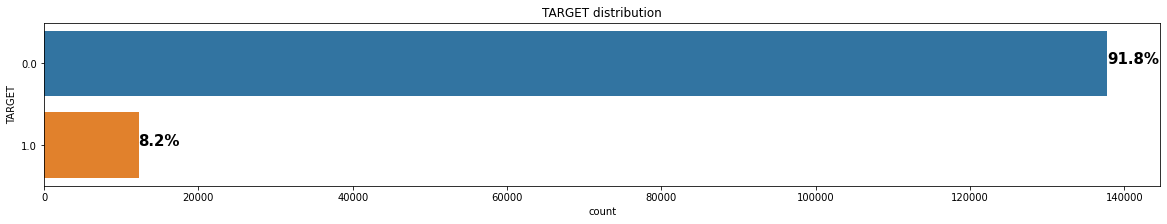

In [5]:
ax, fig = plt.subplots(figsize=(20,3)) 
ax = sns.countplot(y='TARGET', data=data)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(data.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=15, fontweight='bold')

-> On remarque bien le désequilibre du dataset

<hr/>

## III. Séparation Train_Test

* Split tenant compte du désequilibre du dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['TARGET','SK_ID_CURR'], axis = 1),
                                                    data['TARGET'],
                                                    test_size=0.3, random_state=42)

In [7]:
print('Sans SMOTE')
print('train size :', X_train.shape, y_train.shape)
print('test size :', X_test.shape, y_test.shape)
print('pourcentage de 1 dans y_train : ' + str((y_train == 1.).sum() / y_train.shape[0] *100))
print('pourcentage de 1 dans y_test : ' + str((y_test == 1.).sum() / y_test.shape[0] *100))

Sans SMOTE
train size : (104997, 99) (104997,)
test size : (45000, 99) (45000,)
pourcentage de 1 dans y_train : 8.258331190414964
pourcentage de 1 dans y_test : 7.960000000000001


* Génération d'exemples de Train & Test

In [8]:
sm = SMOTE(random_state=2)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [9]:
print('Avec SMOTE')
print('train size :', X_train_sm.shape, y_train_sm.shape)
print('pourcentage de 1 dans y_train : ' + str((y_train_sm == 1.).sum() / y_train_sm.shape[0] *100))

Avec SMOTE
train size : (192652, 99) (192652,)
pourcentage de 1 dans y_train : 50.0


<hr/>

## IV. Modelisation

### 1. Init Models

In [10]:
def gb_models():
    n = len(tf.config.list_physical_devices('GPU'))
    if n>0:
        models = [LGBMClassifier(device='gpu',gpu_platform_id=1,gpu_device_id=0),
                  XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),
                  CatBoostClassifier(task_type="GPU", logging_level='Silent')]
    else:
        models = [LGBMClassifier(device='cpu'),
                  XGBClassifier(tree_method='hist'),
                  CatBoostClassifier(task_type='CPU', logging_level='Silent')]
    return models

In [11]:
models = [LogisticRegression(C = 0.0001, max_iter=100),RandomForestClassifier(max_depth=2, random_state=0)]
models.extend(gb_models())

2022-01-11 20:48:16.973875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/cv2/../../lib64:/var/lib/snapd/lib/gl:/var/lib/snapd/lib/gl32:/var/lib/snapd/void::/snap/jupyter/6/lib
2022-01-11 20:48:17.010565: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 20:48:17.040554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fanjama-Latitude-E6220): /proc/driver/nvidia/version does not exist


In [12]:
models

[LogisticRegression(C=0.0001),
 RandomForestClassifier(max_depth=2, random_state=0),
 LGBMClassifier(device='cpu'),
 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method='hist',
               validate_parameters=None, verbosity=None),

### 2. Functions

In [13]:
def bank_score(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    # vn (vrai négatif) : prédiction de 0 difficulté de paiement et client sans difficulté de paiement
    vn = conf_matrix[0, 0]
    # fp (faux positif) : prédiction de difficulté de paiement mais client sans difficulté de paiement
    fp = conf_matrix[0, 1]
    # fn (faux négatif) : prédiction de 0 difficulté de paiement mais client avec de difficulté de paiement
    fn = conf_matrix[1, 0]
    # vp (vrai positif) : prédiction de difficulté de paiement et client avec difficulté de paiement
    vp = conf_matrix[1, 1]    
    
    vp_poids = 1 # vrai positif -> prédiction vraie
    vn_poids = 1 # vrai négatif -> prédiction vraie
    fp_poids = -1 # faux positif -> opportunité manquée, à éviter si possible
    fn_poids = -10 # faux négatif -> perte, à éviter au maximum

    reel_model = (vn * vn_poids) + (fp * fp_poids) + (fn * fn_poids) + (vp * vp_poids)
    positif_model = ((vn + fp) * vn_poids) + ((fn + vp) * vp_poids) # prédiction toujours vraie
    negatif_model = ((vn + fp) * fp_poids) + ((vp + fn) * fn_poids) # prédiction toujours fausse

    score = (reel_model - negatif_model) / (positif_model - negatif_model)
    # score du model évitant au max les fausses (normalisation par modèle toujours vrai)
    
    return max(0,score)
# score : 1 pour modèle sans risque et 0 pour risque fort de se tromper

In [18]:
def train_models(model, X_train, X_test, y_train, y_test,beta=3):
    model.fit(X_train, y_train)
    output = {
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
        'Accuracy': accuracy_score(y_test, model.predict(X_test)),
        'Precision': precision_score(y_test, model.predict(X_test)),
        'Recall': recall_score(y_test, model.predict(X_test)),
        'F1': f1_score(y_test, model.predict(X_test)),
        'Fbeta': fbeta_score(y_test,model.predict(X_test),beta=beta),
                # beta > 1 pour miniser les faux négatifs
        'Bk_score': bank_score(y_test,model.predict(X_test))      
    }
          
    return output

In [15]:
def run_models(models=models,smote=False):
    name = []
    auc = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fbeta = []
    bscore = []
    time_ = []    

    for model in models:
        start = time.time()
        if smote:
            results = train_models(model, X_train_sm, X_test, y_train_sm, y_test)
        else:
            results = train_models(model, X_train, X_test, y_train, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        fbeta.append(results['Fbeta'])
        bscore.append(results['Bk_score'])
        time_.append(time.time()-start)
        

    #Initialise data of lists
    res_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, fbeta, time_,bscore]).T
    res_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Fbeta', 'Time','Bank_Score']
    res_models.sort_values('AUC', ascending=False, inplace=True)
    
    return res_models

In [16]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=False):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(X_train.columns[indices[i]])

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
    
    plt.show()

### 3. Run Models without SMOTE

* Models comparison

In [19]:
res = run_models(models=models,smote=False)

[20:52:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
res

,Model,AUC,Accuracy,Precision,Recall,F1,Fbeta,Time,Bank_Score
4,CatBoostClassifier,0.763018,0.920644,0.529412,0.027638,0.052534,0.030532,85.91293,0.685131
2,LGBMClassifier,0.759917,0.920778,0.551515,0.025405,0.048572,0.028084,4.202747,0.68464
3,XGBClassifier,0.745548,0.919622,0.455243,0.049693,0.089605,0.054553,8.631211,0.690195
1,RandomForestClassifier,0.71039,0.9204,0.0,0.0,0.0,0.0,7.757298,0.677662
0,LogisticRegression,0.615579,0.920378,0.0,0.0,0.0,0.0,5.173303,0.677645


* Best models based on AUC

In [21]:
best = CatBoostClassifier(task_type='CPU', logging_level='Silent')
best.fit(X_train, y_train)

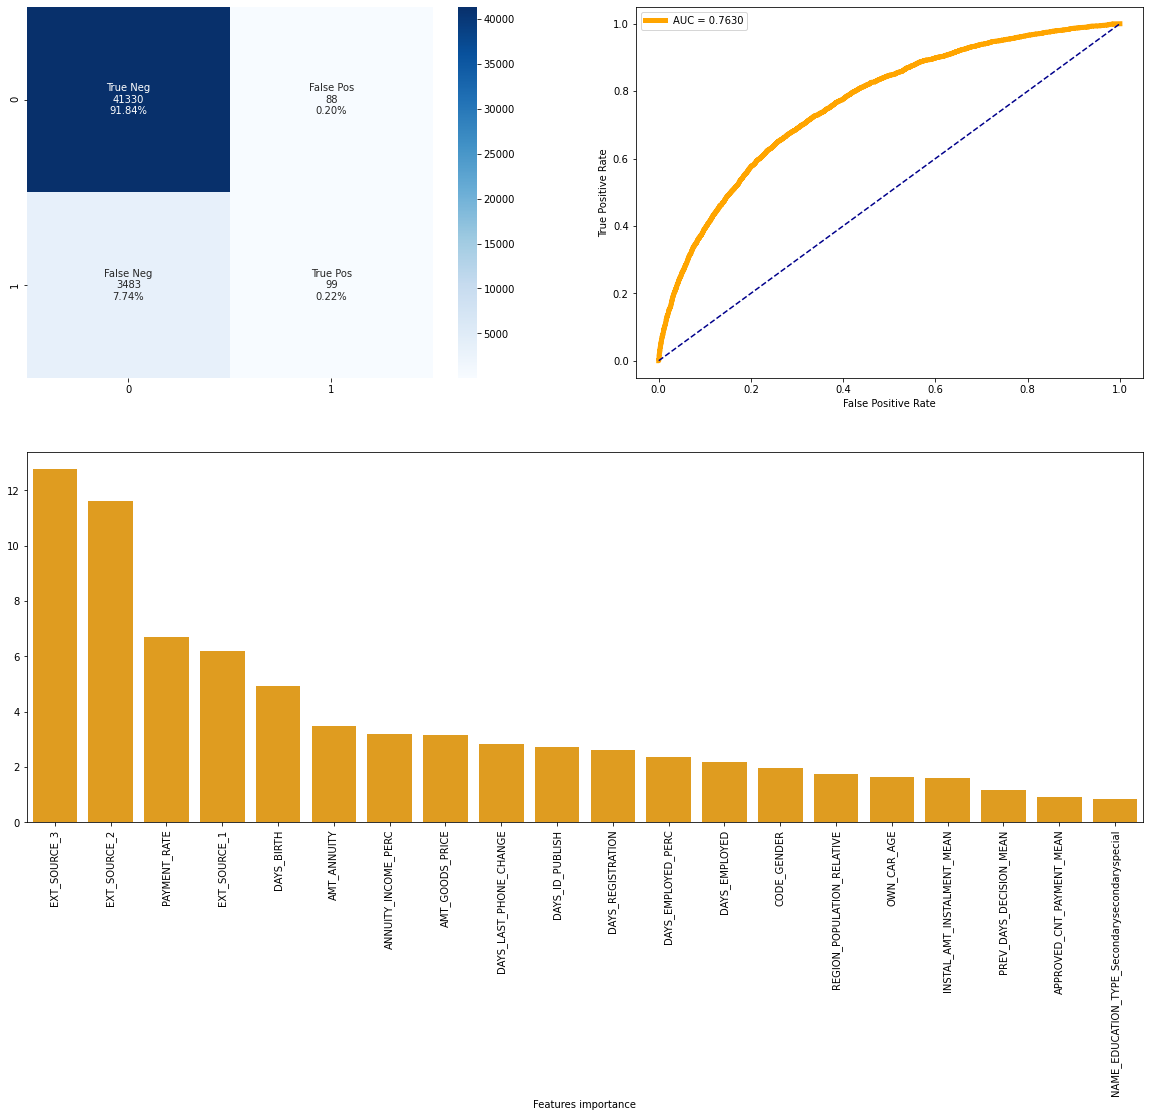

In [22]:
cf_matrix_roc_auc(best, y_test, best.predict(X_test), best.predict_proba(X_test)[:,1],feature_importances=True)

* Best Model based on Bank Score

In [23]:
best_bk = XGBClassifier(tree_method='hist')
best_bk.fit(X_train, y_train)

[20:55:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

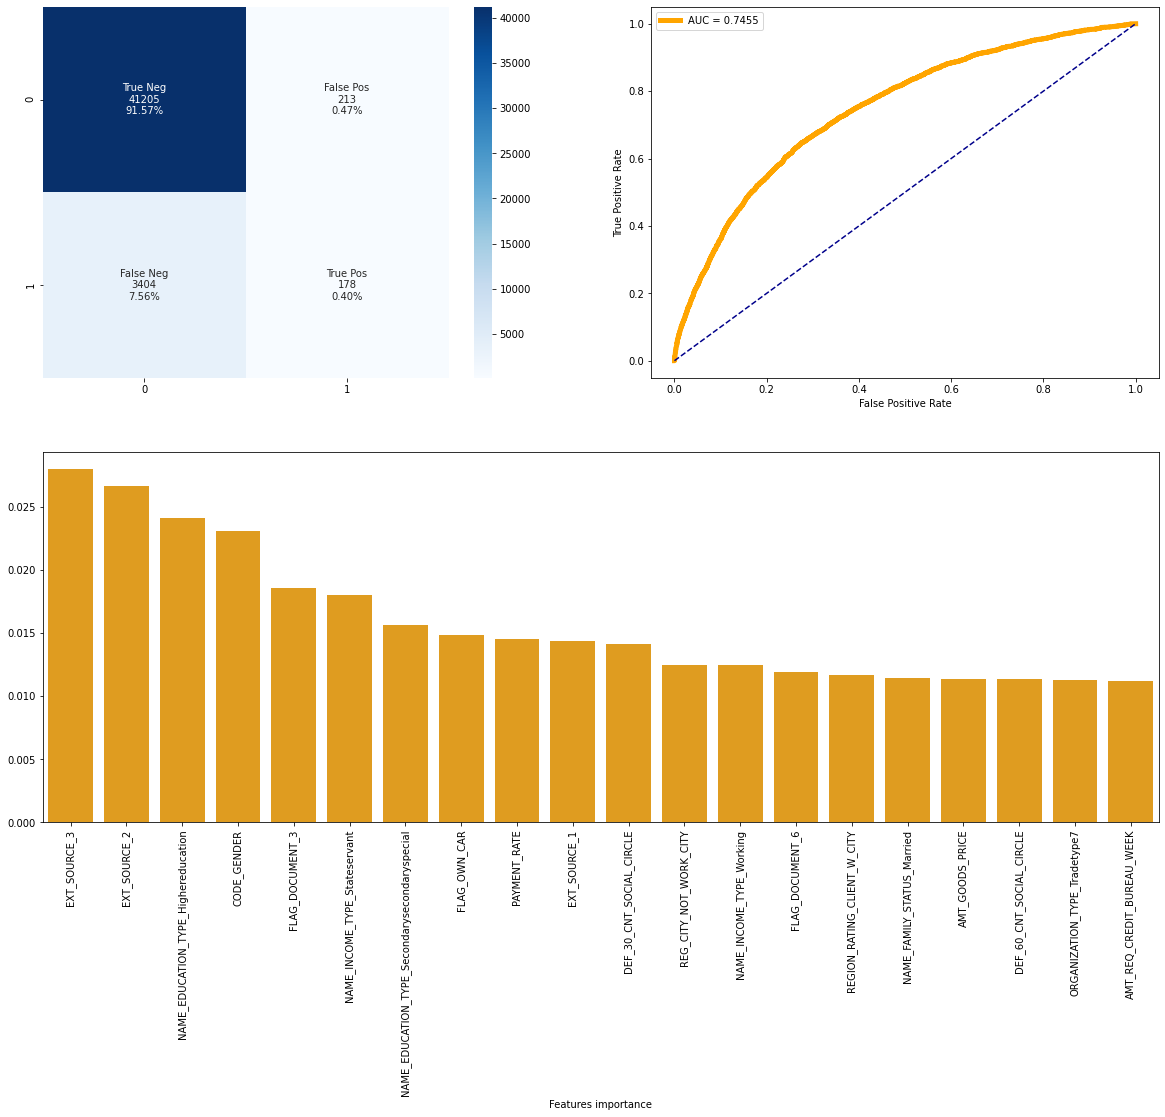

In [24]:
cf_matrix_roc_auc(best_bk, y_test, best_bk.predict(X_test), best_bk.predict_proba(X_test)[:,1],feature_importances=True)

### 4. Run Models with SMOTE

* Models comparison

In [25]:
res_sm = run_models(models=models,smote=True)

[20:56:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
res_sm

,Model,AUC,Accuracy,Precision,Recall,F1,Fbeta,Time,Bank_Score
4,CatBoostClassifier,0.747064,0.919978,0.463602,0.03378,0.062972,0.037232,192.092984,0.68626
2,LGBMClassifier,0.747013,0.918844,0.367424,0.02708,0.050442,0.029844,8.556611,0.683658
3,XGBClassifier,0.740126,0.917778,0.374468,0.049135,0.086871,0.053809,11.845514,0.688689
1,RandomForestClassifier,0.680754,0.810289,0.169975,0.356226,0.230138,0.321047,17.304559,0.690538
0,LogisticRegression,0.60327,0.624667,0.10969,0.522055,0.181289,0.379418,8.057021,0.597605


* Best models based on AUC

In [27]:
best_sm = CatBoostClassifier(task_type='CPU', logging_level='Silent')
best_sm.fit(X_train_sm, y_train_sm)

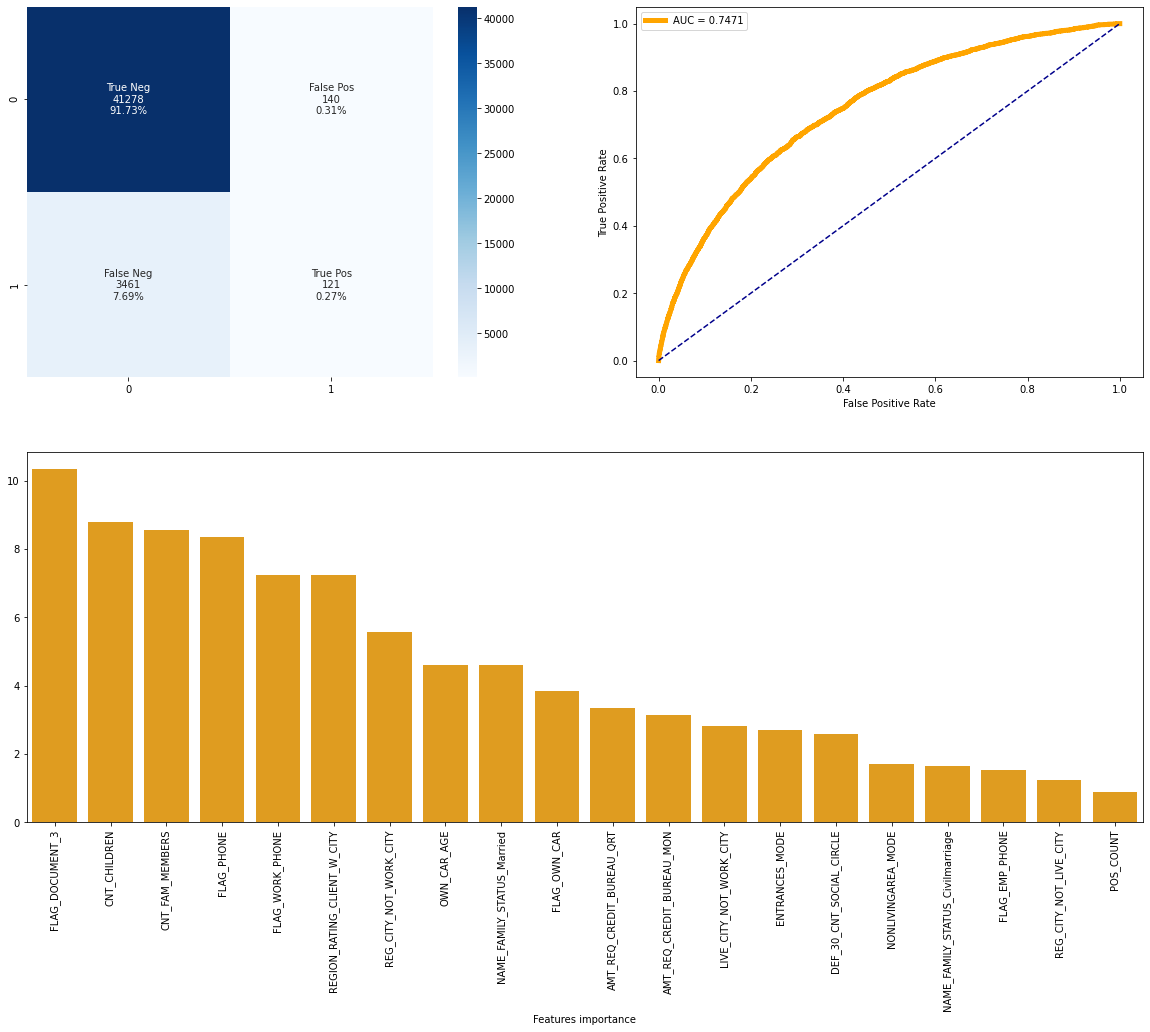

In [28]:
cf_matrix_roc_auc(best_sm, y_test, best_sm.predict(X_test), best_sm.predict_proba(X_test)[:,1],feature_importances=True)

* Best Model based on Bank Score

In [29]:
best_bk_sm = RandomForestClassifier(max_depth=2, random_state=0)#XGBClassifier(tree_method='hist')
best_bk_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=2, random_state=0)

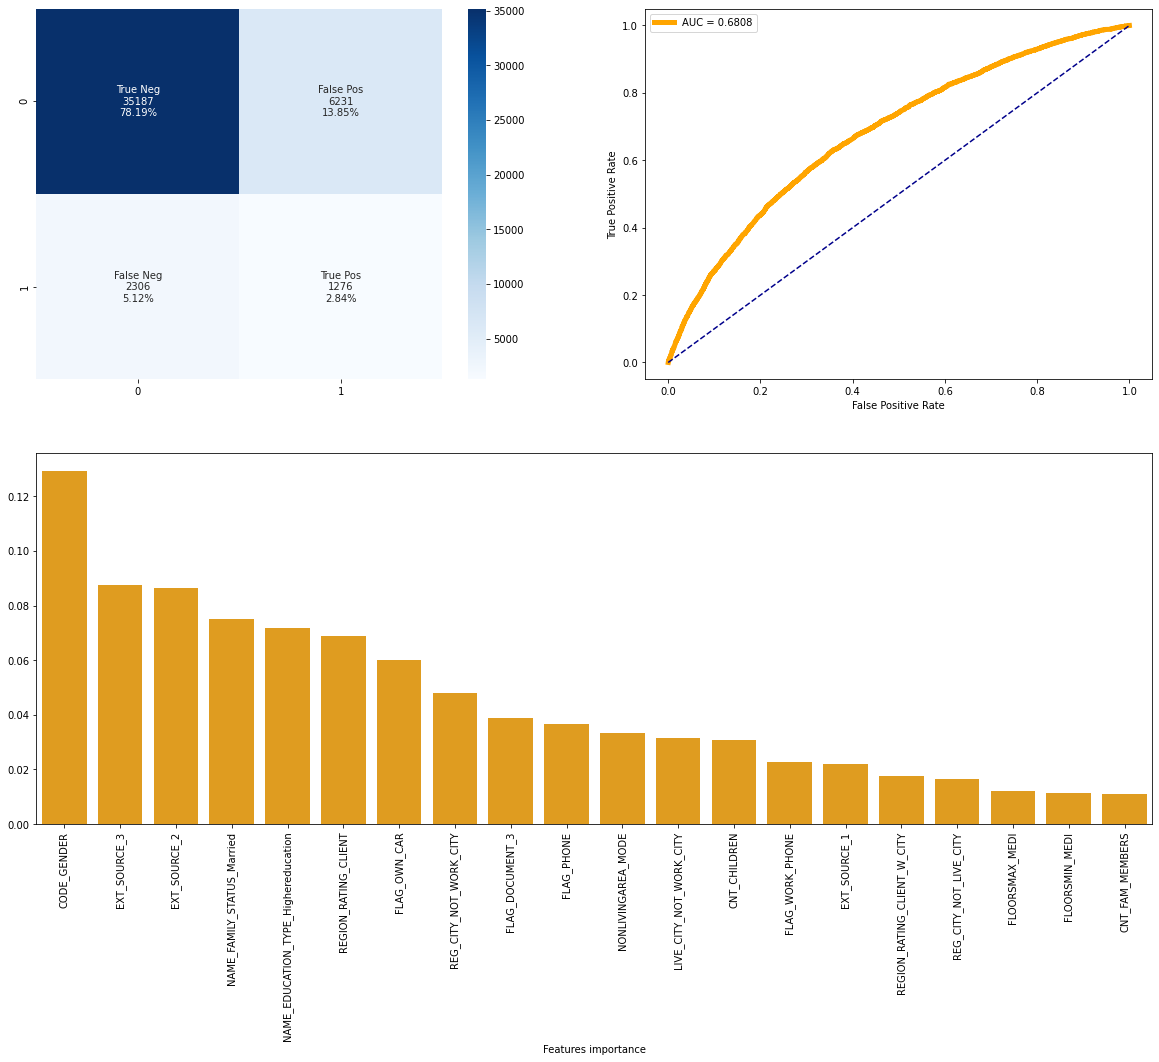

In [30]:
cf_matrix_roc_auc(best_bk_sm, y_test, best_bk_sm.predict(X_test), best_bk_sm.predict_proba(X_test)[:,1],feature_importances=True)

<hr/>

## V. Optimisation du meilleur model

* Choix du modèle

Pour minimiser le risque de perte pour la banque, on choisit de prioriser le Bank score et gardera le modèle RandomForestClassifier pour la suite.
<p> (Celui fitté sur les données avec smote.)</p>

In [31]:
best_model = RandomForestClassifier()

* Optimisation du modèle

In [89]:
param_grid = { 
    'n_estimators': [10,15,20],
    'max_depth' : [2,4,6],
    'random_state': [0,42],
    'max_samples' : [.15,.3,.45]
}

In [90]:
BKscore = make_scorer(bank_score,greater_is_betterbool=True)

In [91]:
grid = GridSearchCV(estimator=best_model,param_grid=param_grid,cv=5,scoring=BKscore)

In [92]:
grid.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'max_samples': [0.15, 0.3, 0.45],
                         'n_estimators': [10, 15, 20],
                         'random_state': [0, 42]},
             scoring=make_scorer(bank_score, greater_is_betterbool=True))

In [93]:
grid.best_params_

{'max_depth': 2, 'max_samples': 0.15, 'n_estimators': 10, 'random_state': 0}

* Modèle optimisé

In [95]:
model = RandomForestClassifier(n_estimators=10,max_samples=0.15,max_depth=2,random_state=0)

In [96]:
model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=2, max_samples=0.15, n_estimators=10,
                       random_state=0)

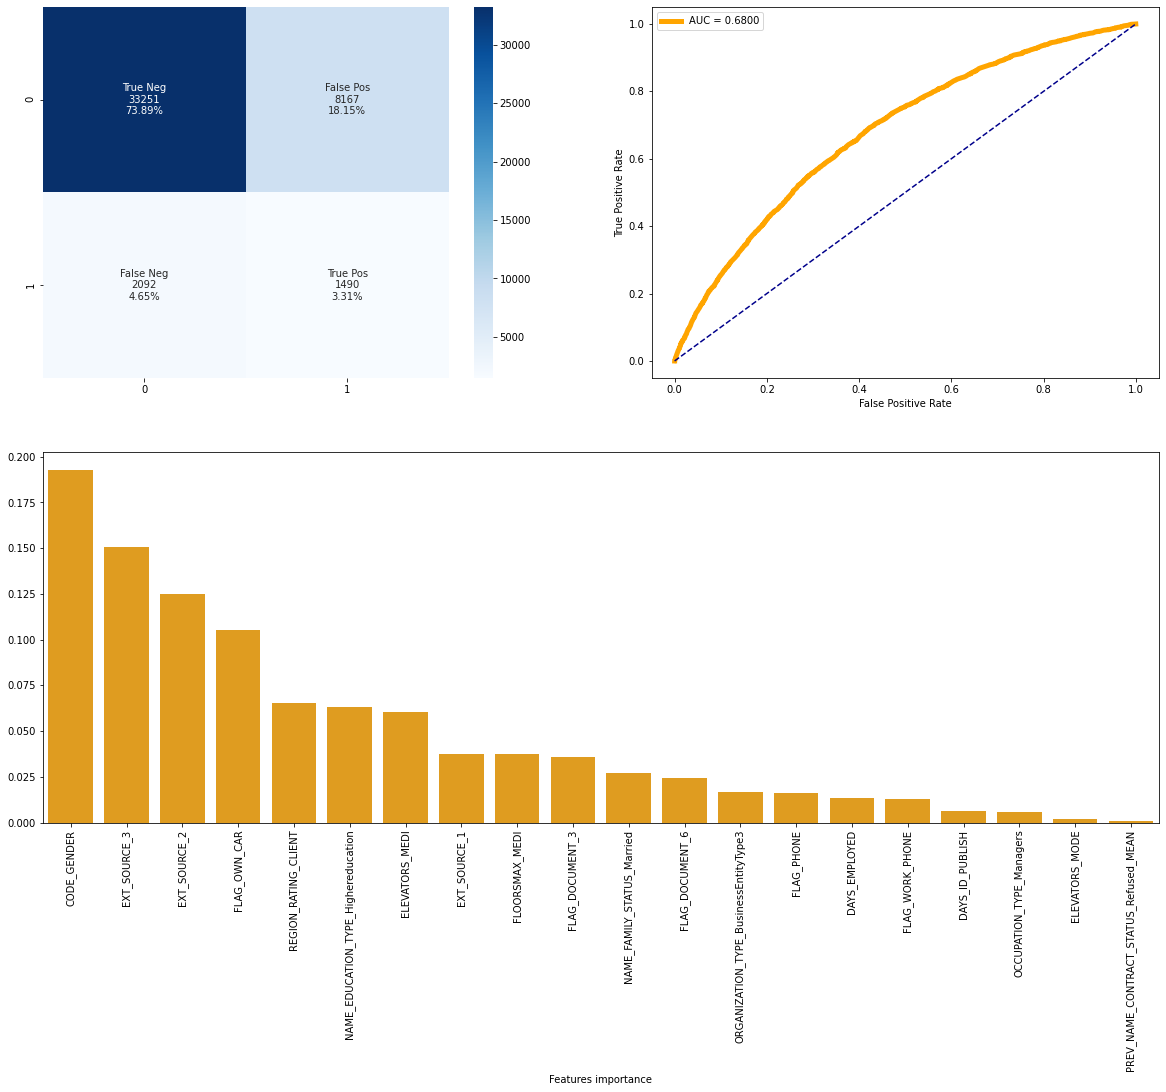

In [97]:
cf_matrix_roc_auc(model, y_test, model.predict(X_test), model.predict_proba(X_test)[:,1],feature_importances=True)

In [98]:
train_models(model, X_train_sm, X_test, y_train_sm, y_test)

{'AUC': 0.6800258886407614,
 'Accuracy': 0.7720222222222223,
 'Precision': 0.1542922232577405,
 'Recall': 0.4159687325516471,
 'F1': 0.22509252964725432,
 'Fbeta': 0.35565103234276163,
 'Bk_score': 0.6781197336343854}

<hr/>

## VI. Interpretabilité

In [99]:
shap.initjs()

### a. Global

In [100]:
feats = list(X_train.columns)

In [101]:
explainer = shap.TreeExplainer(model,X_train_sm)

In [102]:
shap_values = explainer.shap_values(X_test,check_additivity=False)

 98%|===================| 87870/90000 [00:14<00:00]        

In [103]:
shap_expl = explainer(X_test,check_additivity=False)

 99%|===================| 88671/90000 [00:15<00:00]        

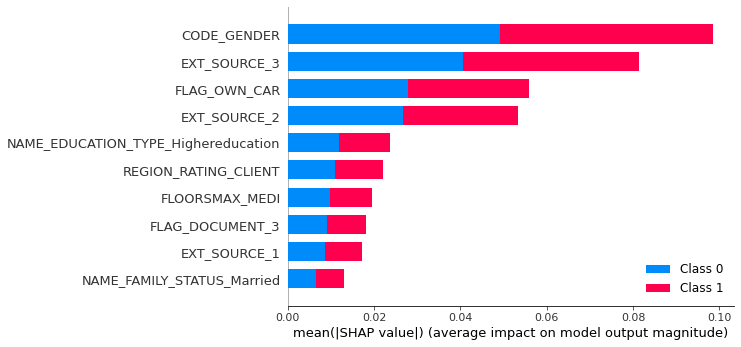

In [104]:
shap.summary_plot(shap_values,feature_names=feats,max_display=10)

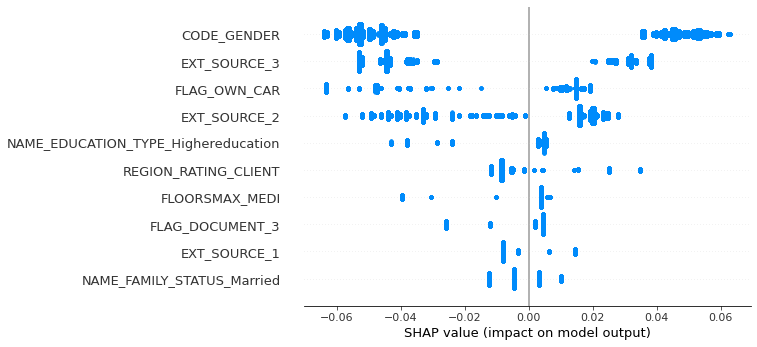

In [105]:
shap.summary_plot(shap_values[1],feature_names=feats,max_display=10)

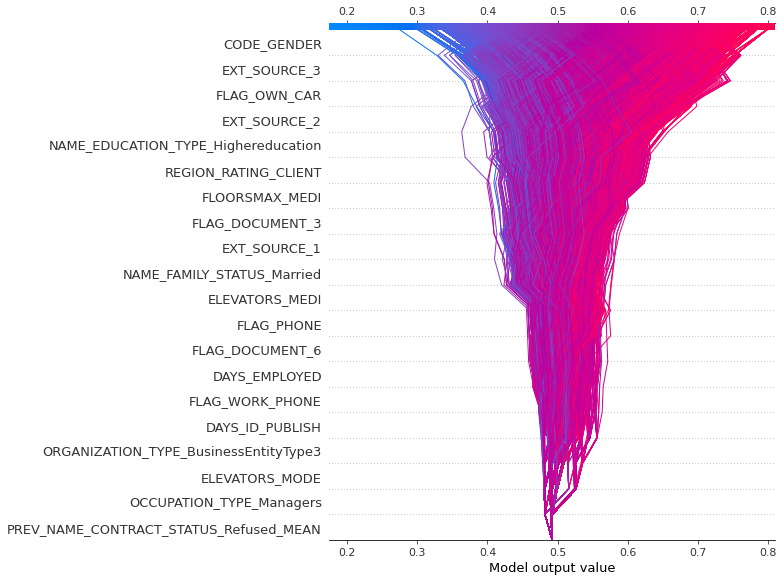

In [106]:
shap.decision_plot(explainer.expected_value[0],shap_values[0],feature_names=feats,ignore_warnings=True)

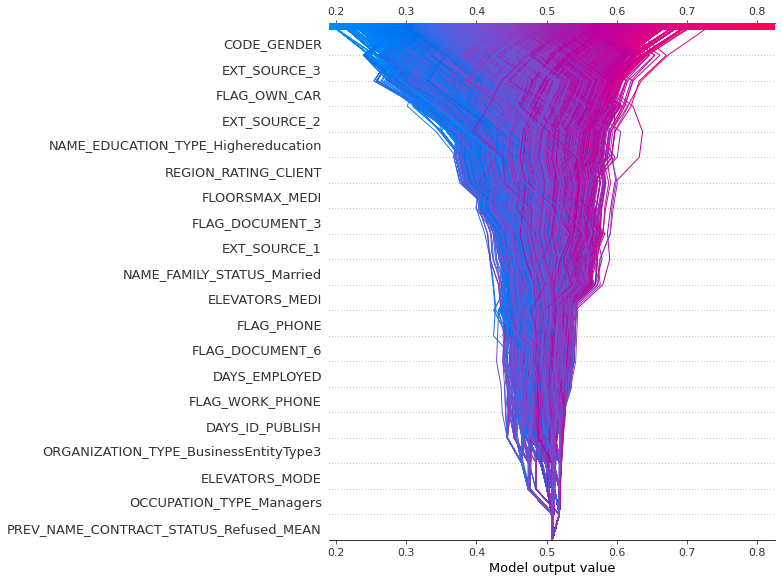

In [107]:
shap.decision_plot(explainer.expected_value[1],shap_values[1],feature_names=feats,ignore_warnings=True)

### b. Local

In [108]:
num_index = X_test.index

In [109]:
i = num_index[0]
choosen_instance = X_test.loc[[i]]

In [110]:
shap_vals = explainer.shap_values(choosen_instance)

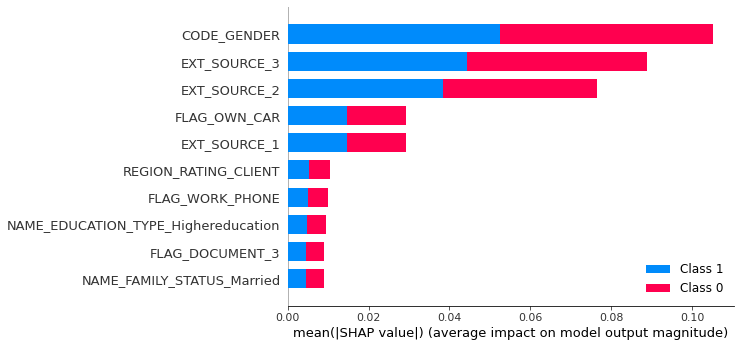

In [111]:
shap.summary_plot(shap_vals,choosen_instance,max_display=10)

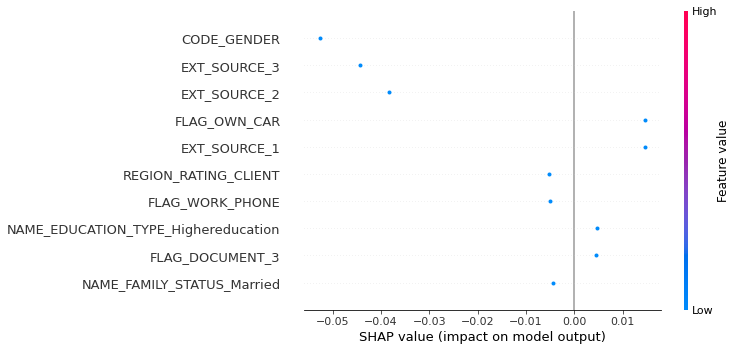

In [112]:
shap.summary_plot(shap_vals[1],choosen_instance,max_display=10)

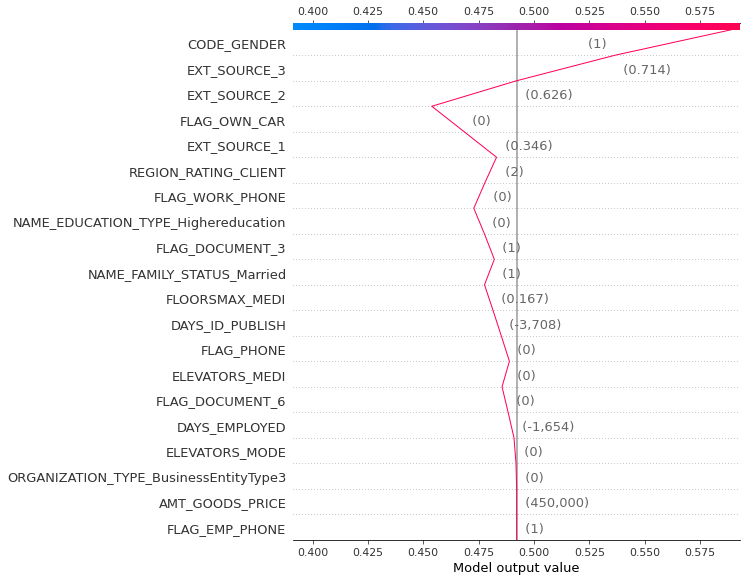

In [113]:
shap.decision_plot(explainer.expected_value[0],shap_vals[0],choosen_instance)

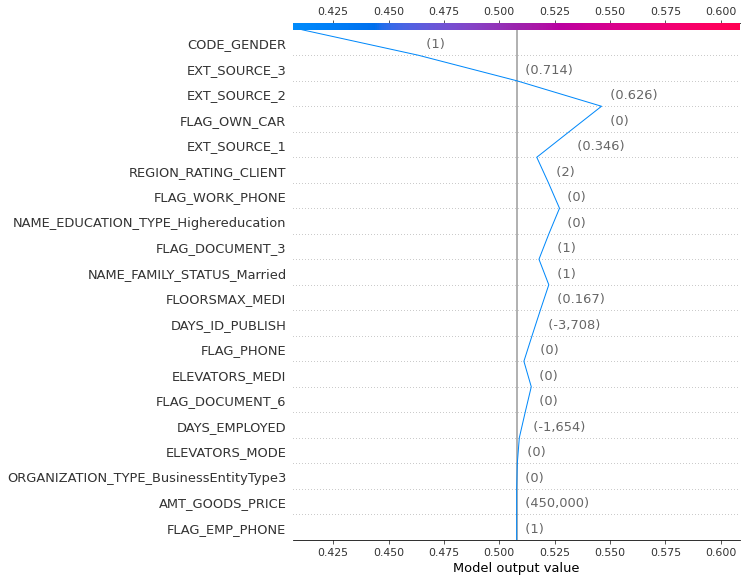

In [114]:
shap.decision_plot(explainer.expected_value[1],shap_vals[1],choosen_instance)

In [115]:
shap.force_plot(explainer.expected_value[0], shap_vals[0], choosen_instance)

In [116]:
shap.force_plot(explainer.expected_value[1], shap_vals[1], choosen_instance)

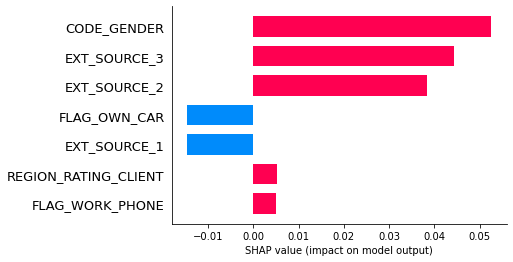

In [117]:
shap.bar_plot(shap_vals[0][0],feature_names=choosen_instance.columns)

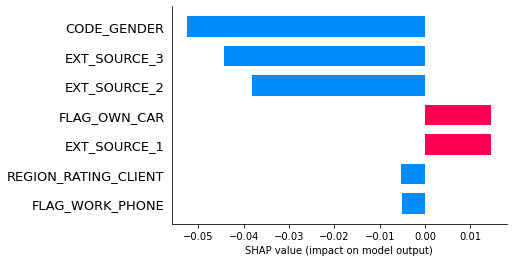

In [118]:
shap.bar_plot(shap_vals[1][0],feature_names=choosen_instance.columns)

<hr/>

## VII. Essai de prédiction

In [119]:
data['SK_ID_CURR'].unique()

array([100002, 100003, 100004, ..., 273886, 273887, 273888])

In [120]:
ID = 100002
ID_data = data[data['SK_ID_CURR']==ID]
ID_to_predict = ID_data[feats]

In [121]:
prediction = model.predict(ID_to_predict)

In [122]:
prediction

array([1.])

In [123]:
data.loc[data['SK_ID_CURR']==ID,'TARGET']

0    1.0
Name: TARGET, dtype: float64

<hr/>

## VIII. Création de fichier pickle pour le modèle

In [124]:
import pickle

pickle_out = open('../Results/model.pkl','wb')
pickle.dump(model,pickle_out)
pickle_out.close()

In [125]:
pickle_out = open('../Results/explainer.pkl','wb')
pickle.dump(explainer,pickle_out)
pickle_out.close()

In [126]:
explainer.save(open('../Results/explainer.mdl', 'wb') , model_saver="auto", masker_saver="auto")